In [1]:
import cv2
import pandas as pd
import numpy as np 
import os
from os.path import isfile, join

In [2]:
# Listando archivos
def list_file(url_path):
    return [join(url_path,f) for f in os.listdir(url_path) if isfile(join(url_path,f))]

In [3]:
#Uniendo diccionario de matrices y tipo de deforestación
def join_dict(dictX:dict,dictY:dict):
    assert len(dictX) == len(dictY), 'diccionarios con diferente longitud'

    data_setsX = []
    data_setsY = []

    for keyX, valueX in dictX.items():
        for keyY, valueY in dictY.items():
            if keyX == keyY:
                data_setsX.append(valueX)
                data_setsY.append(valueY)

    return np.array(data_setsX), np.array(data_setsY)

In [4]:
#extrayendo dataset de imágenes
def get_matrixIMG(url_path:str):
    titles = []
    matriz = []

    for f_img in list_file(url_path):
      x_train_px = cv2.imread(f_img,cv2.IMREAD_GRAYSCALE )
      # reducimos la imagen de 332*332 a 100*100
      x_train_px = cv2.resize(x_train_px, (100,100))
      x_train_cod = join('train_test_data/train/',os.path.basename(f_img))
      matriz.append(x_train_px)
      titles.append(x_train_cod)

    return titles,matriz

### Importando data set

In [5]:
df_train  = './train_test_data/csv/train.csv'
data_train_dir  = './train_test_data/train/'
data_test_dir  = './train_test_data/test/'

In [6]:
df = pd.read_csv(df_train)
dictY = dict(zip(df['example_path'],df['label']))
titles,matriz = get_matrixIMG(data_train_dir)
dictX = dict(zip(titles,matriz))

In [7]:
data_setsX, data_setsY = join_dict(dictX=dictX,dictY=dictY)

_, matrix_val = get_matrixIMG(data_test_dir)
data_valueX = np.array(matrix_val)

### Mostando imágenes

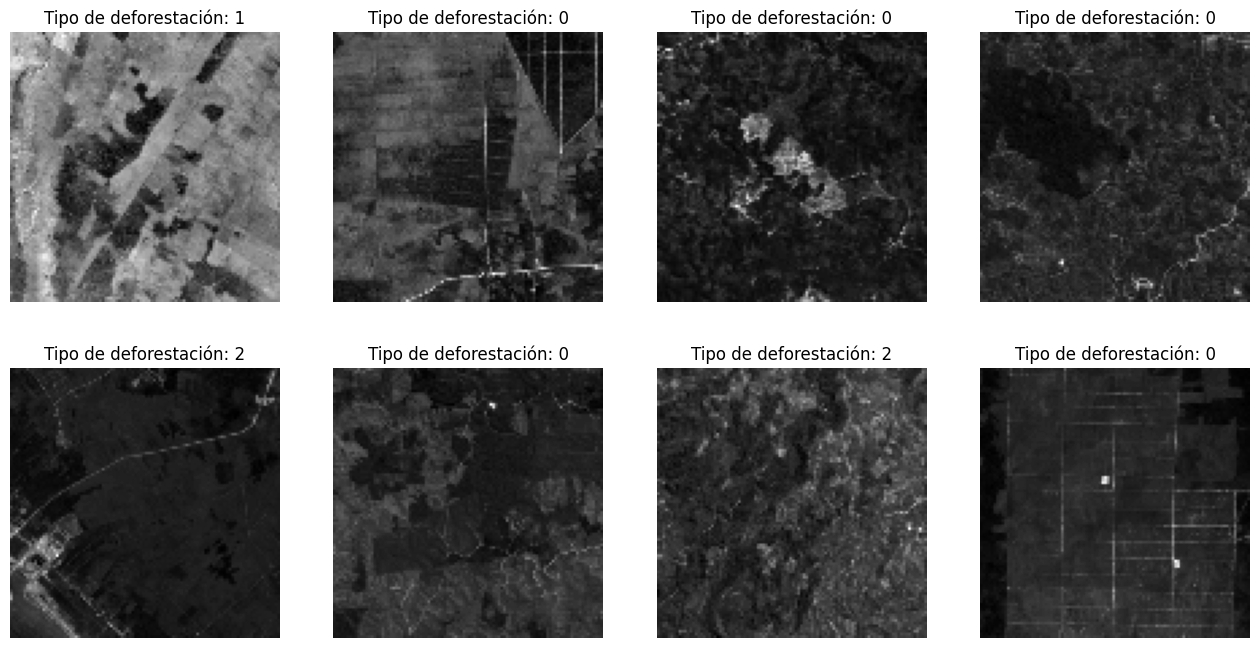

In [9]:
import matplotlib.pyplot as plt

def subplot_number(data_setsX,data_setsY):
    rand_list = [np.random.randint(len(data_setsY)) for i in range(8)]
    _, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.flatten()
    for idx, ax in zip(rand_list, axs):
        ax.imshow(data_setsX[idx],cmap=plt.get_cmap('gray'))
        ax.set_title(f'Tipo de deforestación: {data_setsY[idx]}')
        ax.axis('off')
    plt.show()
    
subplot_number(data_setsX,data_setsY)

### datos de entrenamiento, testeo y predicción

In [10]:
# convertir imágenes en vectores y float32
# 1300 datos para entrenamiento
# 414 datos para testeo
# 635 datos para la predicción

x_train = data_setsX[:1300].reshape(1300, -1).astype(np.float32)/255
y_train = data_setsY[:1300].reshape(1300, 1)

data_testX = data_setsX[1300:].astype(np.float32)/255
data_testY = data_setsY[1300:]

x_test = data_setsX[1300:].reshape(414, -1).astype(np.float32)/255
y_test = data_setsY[1300:].reshape(414, 1)

x_val = data_valueX.reshape(635, -1).astype(np.float32)/255

print(f'{x_train.shape[1]} neuronas de entrada')

10000 neuronas de entrada


### Usar GPU de estar disponible

In [11]:
import torch 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'estamos usando: {device}')

estamos usando: cpu


### Iniciando parámetros

In [12]:
def init_parameters(input_size, neurons):
    
    '''
    input_size -> elementos de entrada, 10000
    neurons -> list [200, 10] con cantidad de neuronas en cada capa
    '''
    
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}

parameters = init_parameters(100*100,[200,3])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b1'].shape)
print(parameters['b2'].shape)

(200, 10000)
(3, 200)
(200, 1)
(3, 1)


In [13]:
def relu(x):
    return np.maximum(0, x)

### Convertimos los arreglos de numpy a tensores

In [14]:
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

x_val_tensor = torch.Tensor(x_val.copy())

type(x_train_tensor)

torch.Tensor

### Modelamos

In [15]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

In [16]:
#instanciar modelo
hidden1 = 200
hidden = 200
lr = 1e-4
epochs = 5
mb_size = 200

model1 = nn.Sequential(
                        nn.Linear(in_features=10000,out_features=hidden1),
                        nn.ReLU(),
                        nn.Linear(in_features=hidden,out_features=3))

optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

### Entrenamos

In [23]:
def create_minibatches(x, y, mb_size, shuffle = True):
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [21]:
def accuracy(model,x,y,mb_size):
    num_correct = 0
    num_total = 0
    model.eval() #poner el modelo en modo evaluación
    model = model.to(device=device) #cargando el modelo en gpu o cpu
    with torch.no_grad():
        for (xi,yi) in create_minibatches(x,y,mb_size):
            #cargamos las variables a la memoria del gpu o cpu
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi) 
            _,pred = scores.max(dim=1) 
            num_correct += (pred == yi.squeeze()).sum() #comprimimos yi ya que pred tiene la forma,shape, (mb_size,)
            num_total += pred.size(0) #se usa size ya que pred es un tensor, en caso de una arrglo se usa shape
        return float(num_correct)/num_total

In [24]:
def train(model,optimizer,mb_size,epochs=64):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi,yi) in create_minibatches(x_train_tensor,y_train_tensor,mb_size):
            model.train() #cambiando a modo entrenamiento
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            #función costo
            cost = F.cross_entropy(input=scores,target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        acc = accuracy(model,x_test_tensor,y_test_tensor,mb_size)
        print(f'epoch:{epoch} ,costo:{cost.item()} ,accuracy:{acc}')  

train(model1,optimizer,mb_size,epochs)

epoch:0 ,costo:0.9408810138702393 ,accuracy:0.533816425120773
epoch:1 ,costo:0.9565765857696533 ,accuracy:0.5434782608695652
epoch:2 ,costo:1.0002399682998657 ,accuracy:0.533816425120773
epoch:3 ,costo:0.9271458983421326 ,accuracy:0.5
epoch:4 ,costo:0.8690586686134338 ,accuracy:0.533816425120773


# Prediciendo

In [25]:
def scores(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

In [26]:
def predict(x):
    scores2, _, _ = scores(x, parameters, relu)
    return np.argmax(scores2)

In [27]:
def plot_number(image):
    # plt.imshow(image.squeeze(),cmap=plt.get_cmap('gray'))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.axis('off')

In [ ]:
idx = np.random.randint(len(y_test))
plot_number1(x_test[idx])
pred = predict(x_test_tensor[idx].reshape(-1, 1))
ver = y_test[idx]
print(f'el valor predicho es: {pred}')
print(f'el valor verdadero es:{ver}')

el valor predicho es: 2
el valor verdadero es:2


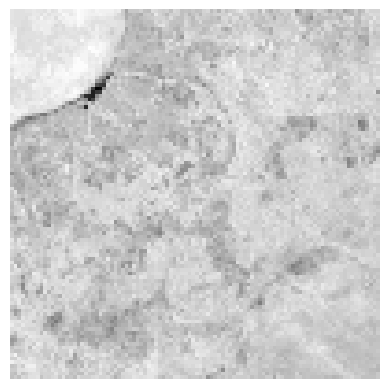

In [33]:
idx = np.random.randint(len(data_testY))
plot_number(data_testX[idx])
pred = predict(x_test[idx].reshape(-1, 1))
ver = data_testY[idx]
print(f'el valor predicho es: {pred}')
print(f'el valor verdadero es:{ver}')

In [ ]:
idx = np.random.randint(len(data_testY))
plot_number(data_testX[idx])
pred = predict(x_test[idx].reshape(-1, 1))
ver = data_testY[idx]
print(f'el valor predicho es: {pred}')
print(f'el valor verdadero es:{ver}')

In [ ]:
x_train = data_setsX[:1300].reshape(1300, -1).astype(np.float32)/255
y_train = data_setsY[:1300].reshape(1300, 1)

data_testX = data_setsX[1300:].astype(np.float32)/255
data_testY = data_setsY[1300:]

x_test = data_setsX[1300:].reshape(414, -1).astype(np.float32)/255
y_test = data_setsY[1300:].reshape(414, 1)

x_val = data_valueX.reshape(635, -1).astype(np.float32)/255

In [43]:
prediccion = []
for i in range(len(x_val)):
    pred = predict(x_val[i].reshape(-1, 1))
    prediccion.append(pred)

In [48]:
import json
import pandas as pd
dataf = pd.DataFrame(prediccion)

In [49]:
dataf.to_json('predictions.json')